In [70]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as gensim_api
from tensorflow.keras import preprocessing
from typing import List

nltk.download("omw-1.4")

FILE_NAME = "covid19_articles_20201231.csv"


[nltk_data] Downloading package omw-1.4 to /Users/sherman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [31]:
df = pd.read_csv("data/" + FILE_NAME)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [32]:
## REMOVE THIS LINE FOR PROD ##
## USED FOR TESTING TO MAKE THINGS FASTER ##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y, random_state=69)
X = X_test[["content"]]
y = y_test
X_train, X_test, y_train, y_test = None, None, None, None
## END ##


In [33]:
def clean_text(text, stemm=False, lemm=False, stopwords=None):
    text = re.sub(r"[^a-z\s]", "", text.lower().strip())
    if stopwords:
        text = [x for x in text.split() if x not in stopwords]

    if stemm:
        stemmer = PorterStemmer()
        text = [stemmer.stem(x) for x in text]

    if lemm:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(x) for x in text]

    return " ".join(text)


STOP_WORDS = set(nltk.corpus.stopwords.words("english"))


In [34]:
X["clean"] = X["content"].apply(
    lambda x: clean_text(x, lemm=True, stopwords=STOP_WORDS)
)


# TFIDF Vectors


In [35]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_features=10000, ngram_range=(1, 2)
)

tfidf_corpus = X["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)


(18453, 10000)


In [36]:
## reduce dimensionality by using Chi-Square test
## generate most significant words
tfidf_X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95

_ = pd.DataFrame()
for category in np.unique(y):
    chi_square, p = chi2(tfidf_vectors, y == category)
    _ = pd.concat(
        [_, pd.DataFrame({"feature": tfidf_X_names, "score": 1 - p, "y": category})]
    )
    _ = _.sort_values(["y", "score"], ascending=[True, False])
    _ = _[_["score"] > p_value_limit]

tfidf_X_names = _["feature"].unique().tolist()


In [37]:
## regenerate vectors
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    vocabulary=tfidf_X_names
)

tfidf_corpus = X["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)


(18453, 2535)


In [38]:
## save it for future use
scipy.sparse.save_npz("processed_data/tfidf_sparse_matrix", tfidf_vectors)
tfidf_vectors = scipy.sparse.load_npz("processed_data/tfidf_sparse_matrix.npz")
tfidf_vectors.shape


(18453, 2535)

# Word Embeddings (construct our own)

can just use `nlp = gensim_api.load("word2vec-google-news-300")`


In [58]:
we_corpus = X["clean"]

# unigrams
_ = []
for row in we_corpus:
    _.append(row.split())
we_corpus = _

bigram_phraser = Phraser(Phrases(we_corpus, delimiter=" ", min_count=5, threshold=10))



In [59]:
b_set = set()
for row in we_corpus:
    for word in bigram_phraser[row]:
        if " " in word:
            b_set.add(word)
print(list(b_set)[:10])


['former aide', 'tallinna sadam', 'podcast host', 'statement guarantee', 'de juniac', 'pero en', 'cope surge', 'oz oz', 'chargeability anomaly', 'cueq including']


In [60]:
VECTOR_SIZE = 300
nlp = gensim.models.word2vec.Word2Vec(
    we_corpus, vector_size=VECTOR_SIZE, window=8, min_count=1, sg=1, epochs=5
)


In [61]:
nlp.wv["former"][:10]

array([-0.1196797 ,  0.13856633, -0.14579308, -0.49601895, -0.09080414,
       -0.35323527,  0.17184779,  0.18997231, -0.0082561 , -0.1928952 ],
      dtype=float32)

In [62]:
WORD_EMBEDDINGS_FILEPATH = "processed_data/local_word_embeddings.model"
nlp.save(WORD_EMBEDDINGS_FILEPATH)
nlp = gensim.models.Word2Vec.load(WORD_EMBEDDINGS_FILEPATH)
nlp.wv["former"][:10]


array([-0.1196797 ,  0.13856633, -0.14579308, -0.49601895, -0.09080414,
       -0.35323527,  0.17184779,  0.18997231, -0.0082561 , -0.1928952 ],
      dtype=float32)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/k3/j42_pl713ll6h7jgr35bjjnr0000gn/T/ipykernel_1534/3116516782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["input"].iloc[:1] = 1


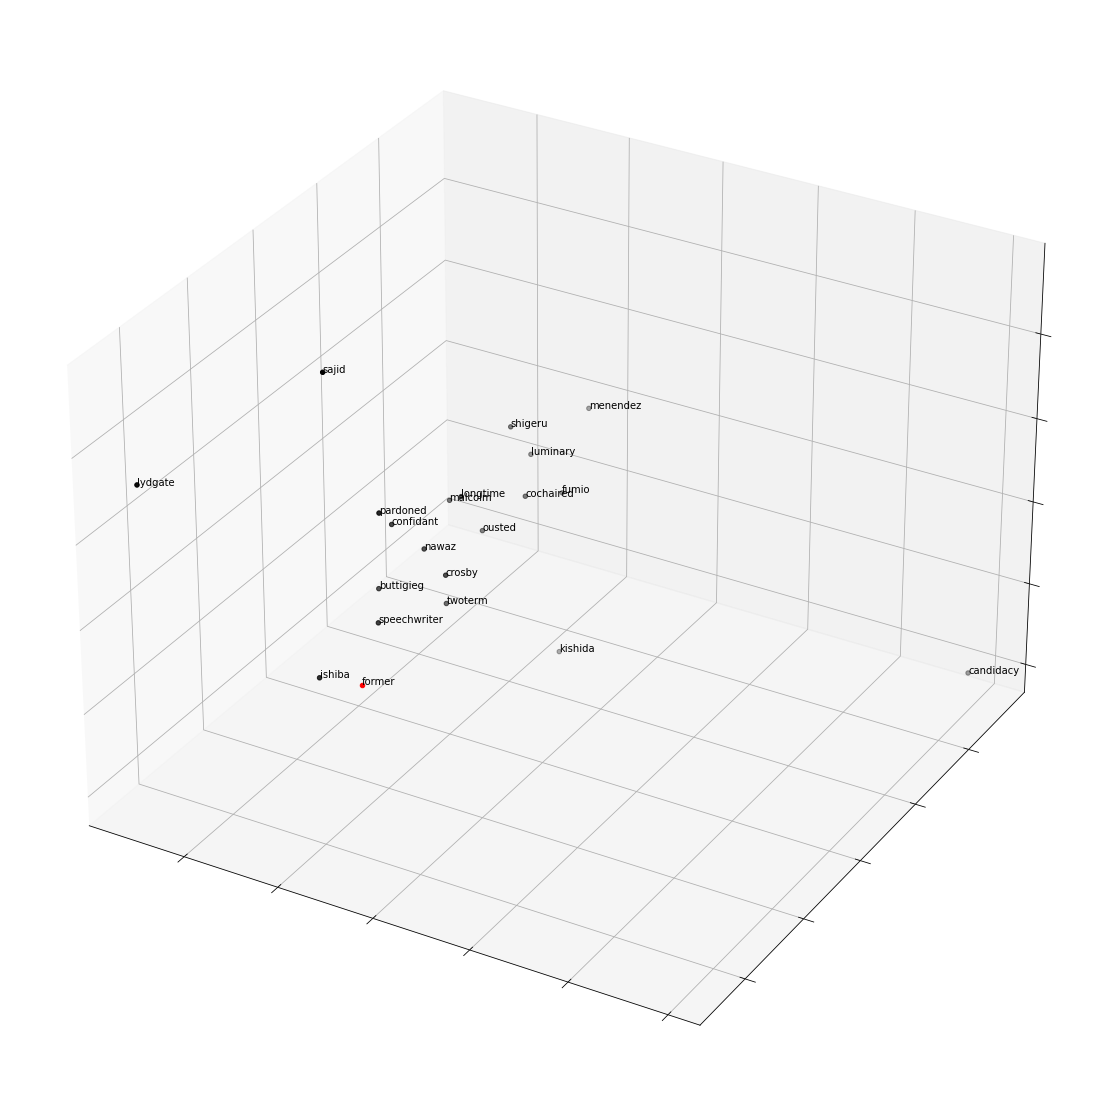

In [63]:
## similar words to "former"
word = "former"
fig = plt.figure(figsize=(20, 20))

total = [word] + [x[0] for x in nlp.wv.most_similar(word, topn=20)]
_ = nlp.wv[total]

pca = manifold.TSNE(init="pca", n_components=3)
_ = pca.fit_transform(_)

_df = pd.DataFrame(_, index=total, columns=["x", "y", "z"])
_df["input"] = 0
_df["input"].iloc[:1] = 1

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    _df[_df["input"] == 0]["x"],
    _df[_df["input"] == 0]["y"],
    _df[_df["input"] == 0]["z"],
    c="black",
)
ax.scatter(
    _df[_df["input"] == 1]["x"],
    _df[_df["input"] == 1]["y"],
    _df[_df["input"] == 1]["z"],
    c="red",
)
ax.set(
    xlabel=None,
    ylabel=None,
    zlabel=None,
    xticklabels=[],
    yticklabels=[],
    zticklabels=[],
)
for i, row in _df[["x", "y", "z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=i)


In [71]:
## feature engineering
we_corpus = list(bigram_phraser[we_corpus])

tokenizer = preprocessing.text.Tokenizer(
    lower=True,
    split=" ",
    oov_token="NaN",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
)
tokenizer.fit_on_texts(we_corpus)
we_vocab: dict = tokenizer.word_index

we_sequences: List[List[int]] = tokenizer.texts_to_sequences(we_corpus)

we_X = preprocessing.sequence.pad_sequences(
    we_sequences, maxlen=15, padding="post", truncating="post"
)


In [74]:
## create embedding matrix
we_embeddings = np.zeros((len(we_vocab) + 1, VECTOR_SIZE))

for w, i in we_vocab.items():
    if i < len(we_embeddings):
        we_embeddings[i] = nlp.wv[word]


In [81]:
we_embeddings[69]

array([-1.19679697e-01,  1.38566330e-01, -1.45793080e-01, -4.96018946e-01,
       -9.08041447e-02, -3.53235275e-01,  1.71847790e-01,  1.89972311e-01,
       -8.25609639e-03, -1.92895204e-01, -1.37648538e-01,  1.10226348e-01,
       -4.50470671e-02, -2.06093132e-01, -1.50112584e-01,  2.41566021e-02,
        6.61793500e-02,  3.23584616e-01,  1.78776309e-02, -3.78254391e-02,
        5.78913055e-02, -2.87878364e-01,  1.17694646e-01, -1.72844708e-01,
       -2.29323760e-01, -5.54134436e-02, -1.04531888e-02,  4.04006690e-01,
       -2.68148601e-01, -3.39432657e-01, -3.77874792e-01, -8.48407820e-02,
       -4.77068946e-02,  3.23438458e-02,  9.19255540e-02,  1.11120939e-01,
        8.34636041e-04, -4.82456908e-02,  1.06305629e-02, -2.61808280e-02,
        2.89777786e-01,  2.67847050e-02,  2.68626273e-01, -1.45037258e-02,
       -2.39353385e-02, -1.53668910e-01,  5.88725992e-02, -1.08408473e-01,
        2.00976208e-01, -1.35043770e-01, -4.36771363e-01,  1.31744564e-01,
        3.21603209e-01,  

In [84]:
WE_FILEPATH = "processed_data/word_embeddings"
np.save(WE_FILEPATH, we_embeddings)
we_embeddings = np.load(WE_FILEPATH + ".npy")
we_embeddings[69]


array([-1.19679697e-01,  1.38566330e-01, -1.45793080e-01, -4.96018946e-01,
       -9.08041447e-02, -3.53235275e-01,  1.71847790e-01,  1.89972311e-01,
       -8.25609639e-03, -1.92895204e-01, -1.37648538e-01,  1.10226348e-01,
       -4.50470671e-02, -2.06093132e-01, -1.50112584e-01,  2.41566021e-02,
        6.61793500e-02,  3.23584616e-01,  1.78776309e-02, -3.78254391e-02,
        5.78913055e-02, -2.87878364e-01,  1.17694646e-01, -1.72844708e-01,
       -2.29323760e-01, -5.54134436e-02, -1.04531888e-02,  4.04006690e-01,
       -2.68148601e-01, -3.39432657e-01, -3.77874792e-01, -8.48407820e-02,
       -4.77068946e-02,  3.23438458e-02,  9.19255540e-02,  1.11120939e-01,
        8.34636041e-04, -4.82456908e-02,  1.06305629e-02, -2.61808280e-02,
        2.89777786e-01,  2.67847050e-02,  2.68626273e-01, -1.45037258e-02,
       -2.39353385e-02, -1.53668910e-01,  5.88725992e-02, -1.08408473e-01,
        2.00976208e-01, -1.35043770e-01, -4.36771363e-01,  1.31744564e-01,
        3.21603209e-01,  